In [7]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds
import os
import numpy as np


gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.per_process_gpu_memory_fraction = 0.9
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


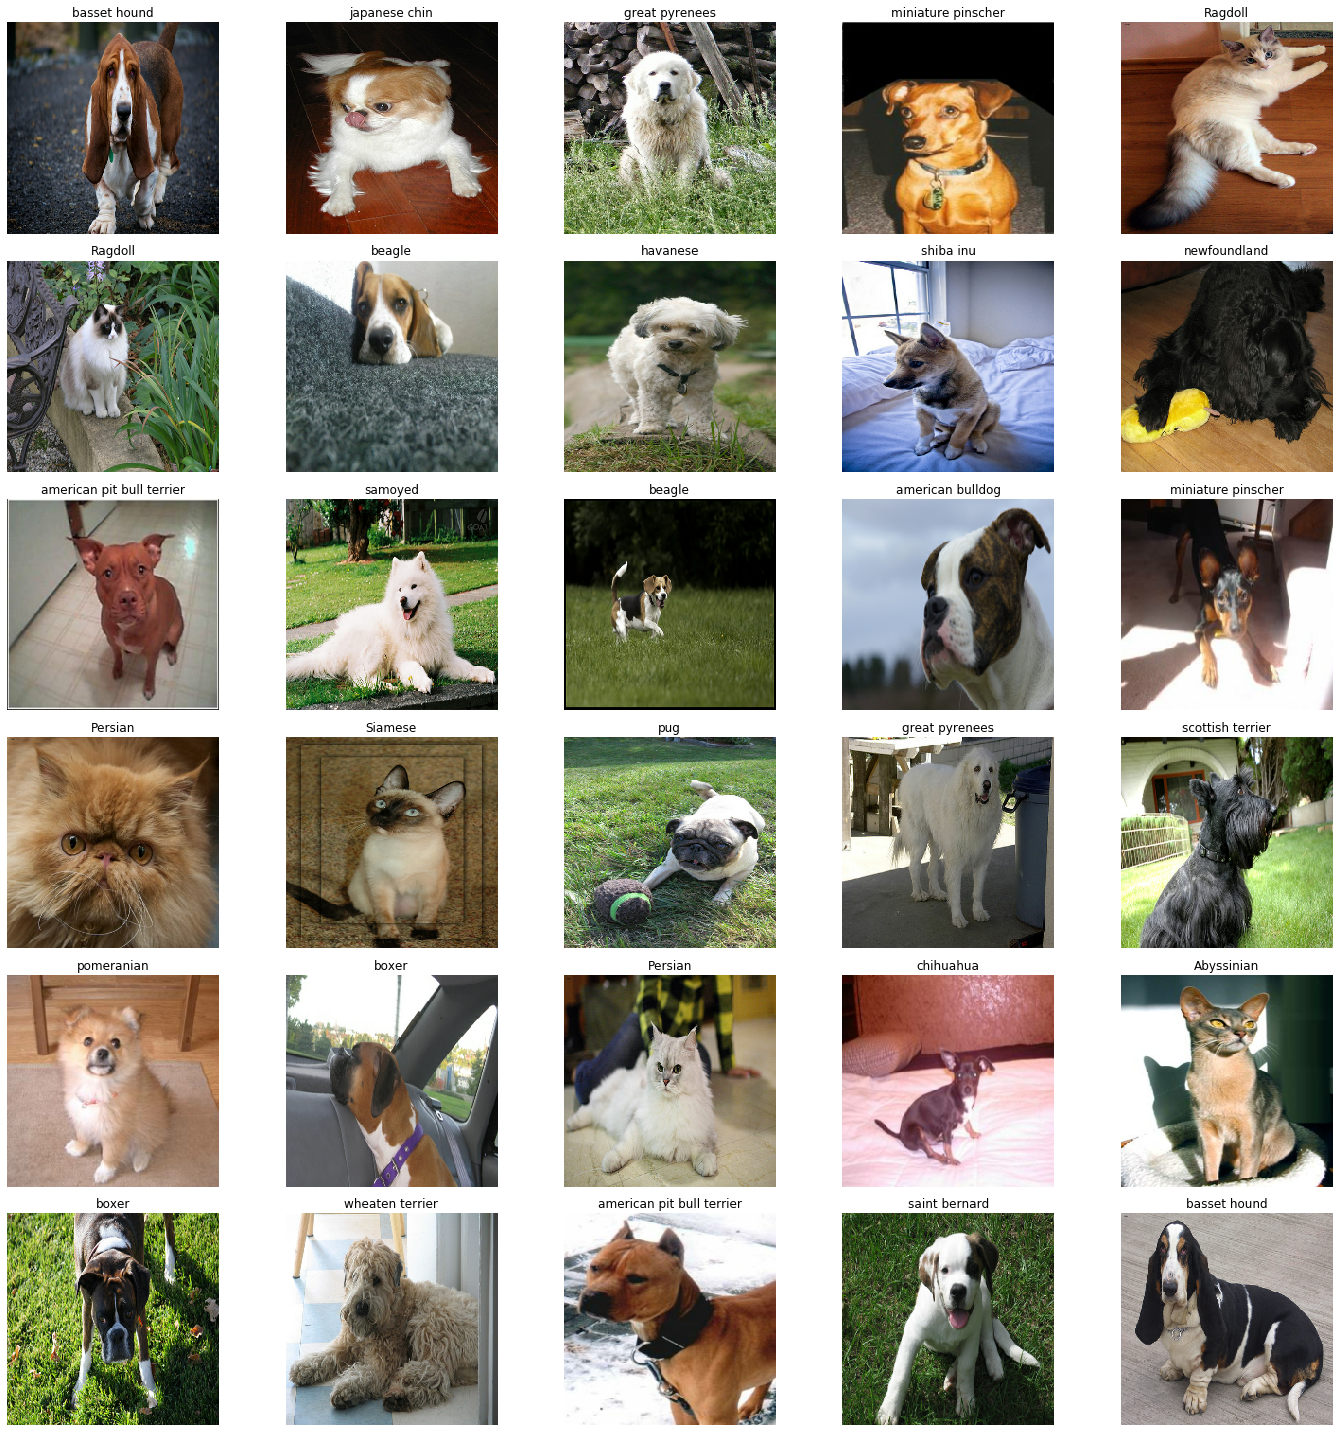

In [8]:
# 1) TFDS label to split dataset

dataset, info = tfds.load('oxford_iiit_pet', with_info=True)

raw_train = dataset['train']
raw_test = dataset['test']

############################################################

# 2) Datasets to (image, label) datasets

IMG_SIZE = (224, 224)

def format_data(datapoint):
    image = datapoint['image']
    label = datapoint['label']
    
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, IMG_SIZE)
    return image, label

train = raw_train.map(format_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = raw_test.map(format_data)

def generate_name_id_pairs(datapoint):
    name = datapoint['file_name']
    label = datapoint['label']
    return name, label

name_id_pairs = raw_train.map(generate_name_id_pairs)

feat_dict = {}
for name, label in name_id_pairs:
    feat_dict[label.numpy()] = ' '.join(name.numpy().decode("utf-8").split('_')[:-1])

############################################################

# 3) Datasets to batched dataset

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

############################################################

# 4) Datasets to image display

def plotImages(batch):
    img, label = batch
    
    plt.figure(figsize=(20,20))
    
    for n in range(30):
        
        plt.subplot(6,5,n+1)
        plt.imshow(img[n])
        plt.title(feat_dict[label[n].numpy()])
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

sample_train_batch = next(iter(train_batches))
plotImages(sample_train_batch) 


In [3]:
# feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

# feature_layer = hub.KerasLayer(feature_extractor_url, input_shape=IMG_SHAPE)
# feature_layer.trainable = False

In [9]:
OUTPUT_CHANNELS = 3
IMG_SHAPE = (*IMG_SIZE, OUTPUT_CHANNELS)
NUM_CLASSES = info.features['label'].num_classes

LEARNING_RATE = 0.001 / 2

INITIAL_EPOCHS = 20
FINE_TUNE_EPOCHES = 10
TOTAL_EPOCHS =  INITIAL_EPOCHS + FINE_TUNE_EPOCHES
    
base_model = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model.trainable = False
pooling_layer = keras.layers.GlobalAveragePooling2D()

model = tf.keras.Sequential([
    base_model,
    pooling_layer,
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=LEARNING_RATE),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_batches, 
                    epochs=INITIAL_EPOCHS,
                    validation_data=test_batches)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 37)               

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential_1/resnet50v2/conv1_conv/Conv2D (defined at /home/philiip/.virtualenvs/jupyter/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_distributed_function_46223]

Function call stack:
distributed_function


In [38]:
base_model.trainable = True

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

# model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=LEARNING_RATE // 10),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

history_fine = model.fit(train_batches, 
                    epochs=TOTAL_EPOCHS,
                    initial_epoch=INITIAL_EPOCHS,
                    validation_data=test_batches)

Epoch 2/11
58/58 [==============================] - 11s 190ms/step - loss: 0.6436 - accuracy: 0.8405 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/11
58/58 [==============================] - 11s 189ms/step - loss: 0.4316 - accuracy: 0.8986 - val_loss: 0.6612 - val_accuracy: 0.7863
Epoch 4/11
58/58 [==============================] - 11s 190ms/step - loss: 0.3201 - accuracy: 0.9258 - val_loss: 0.6434 - val_accuracy: 0.7926
Epoch 5/11
58/58 [==============================] - 11s 187ms/step - loss: 0.2555 - accuracy: 0.9465 - val_loss: 0.6097 - val_accuracy: 0.8021
Epoch 6/11
58/58 [==============================] - 11s 194ms/step - loss: 0.2122 - accuracy: 0.9563 - val_loss: 0.5723 - val_accuracy: 0.8046
Epoch 7/11
58/58 [==============================] - 11s 189ms/step - loss: 0.1788 - accuracy: 0.9723 - val_loss: 0.5725 - val_accuracy: 0.8111
Epoch 8/11
58/58 [==============================] - 11s 189ms/step - loss: 0.1561 - accuracy: 0.9717 - val_loss: 0.5833 - val_accuracy

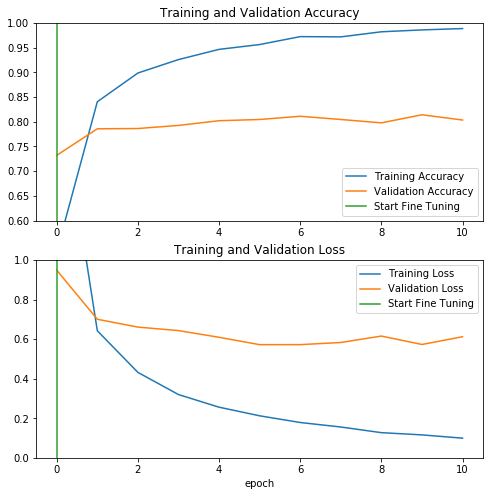

In [39]:
acc  = history.history['accuracy'] +  history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([INITIAL_EPOCHS-1,INITIAL_EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([INITIAL_EPOCHS-1,INITIAL_EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
